In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-04_16-48_20180601_20191231_lock_periods_by_1.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.005622489959839358

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
NQ       0.25
YM       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    22887.10
GC    13282.24
NQ    19585.40
YM    20604.80
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

76359.54000000001

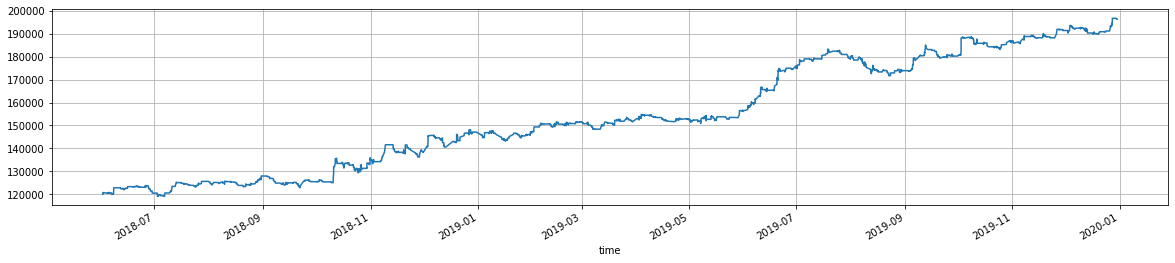

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     274
 GC     528
 NQ    1326
 YM     362
 Name: action, dtype: int64,
 2490)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.665049
 GC    1.281553
 NQ    3.218447
 YM    0.878641
 Name: action, dtype: float64,
 6.043689320388349)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     575.40
GC    1277.76
NQ    2784.60
YM     760.20
Name: commission, dtype: float64

In [16]:
df.commission.sum()

5397.960000000001

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,50.31,547.41,-262.68,2.08,53.26,264.0
NQ,0.40,29.54,447.37,-246.92,1.81,30.80,663.0
YM,0.43,113.84,752.98,-370.17,2.03,112.78,181.0
ES,0.45,167.06,1019.39,-537.53,1.90,163.08,137.0
total,0.41,61.33,584.74,-297.05,1.97,64.48,1245.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.088101,0.112411,0.417114,0.662348
GC,-0.088101,1.000000,0.073676,0.040816,0.334811
NQ,0.112411,0.073676,1.000000,0.209007,0.634519
YM,0.417114,0.040816,0.209007,1.000000,0.702224
total,0.662348,0.334811,0.634519,0.702224,1.000000


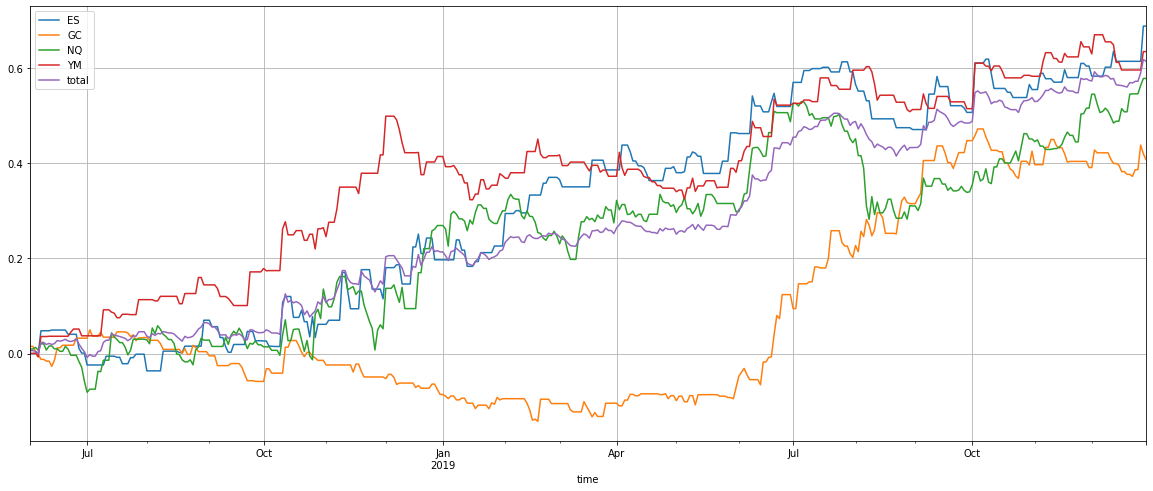

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

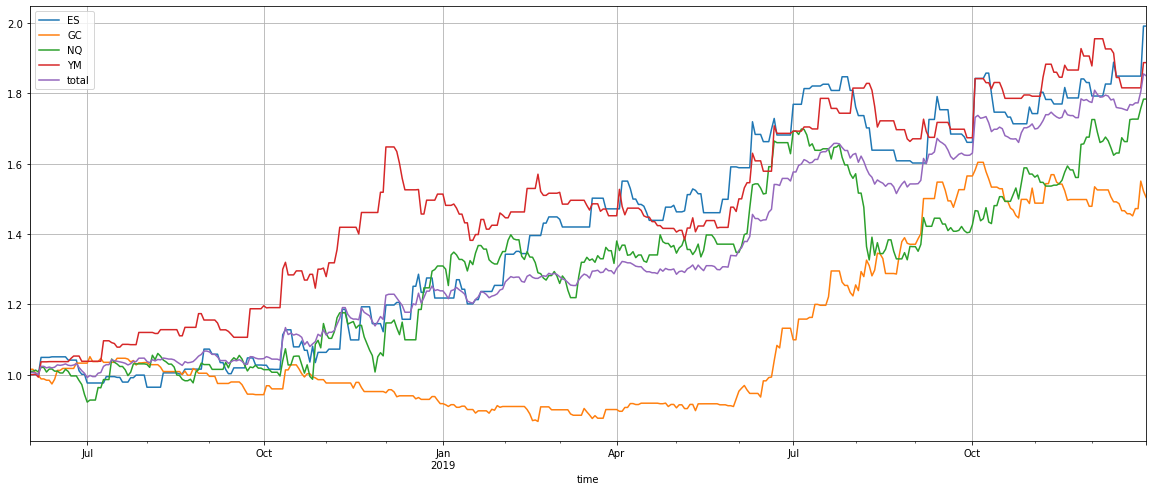

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.523972,0.283323,0.424775,0.474832,0.456772
Cumulative returns,0.991374,0.503560,0.783868,0.887472,0.849832
Annual volatility,0.304586,0.208145,0.302885,0.253617,0.160899
Sharpe ratio,1.532013,1.301030,1.318367,1.656426,2.418973
Calmar ratio,3.946047,1.616094,1.937591,2.945276,5.296820
Stability,0.933687,0.509586,0.852808,0.880647,0.962516
Max drawdown,-0.132784,-0.175314,-0.219228,-0.161218,-0.086235
Omega ratio,1.579689,1.368335,1.305240,1.600142,1.642489
Sortino ratio,3.176227,2.705793,2.378607,3.590460,5.367779
Skew,2.249346,1.995263,1.190000,2.426764,2.222423


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,0.09,3.27,-5.66,3.80,0.37
2018-07-31,-0.24,0.15,9.24,7.90,4.30
2018-08-31,7.41,-2.93,-0.19,3.15,1.92
2018-09-30,-4.22,-6.07,-0.98,2.77,-2.08
2018-10-31,3.51,4.53,12.46,9.74,7.94
2018-11-30,5.51,-3.43,-8.03,16.55,2.57
2018-12-31,8.55,-3.62,24.27,-0.35,7.04
2019-01-31,2.95,-0.88,3.14,-3.94,0.43
2019-02-28,15.53,-1.03,-5.18,4.28,3.31


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       99.0
GC       50.0
NQ       78.0
YM       89.0
total    85.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 21:00:00,ES,BUY,2893.75,3283.30
2018-11-09 09:08:00,ES,SELL,2796.25,3170.80
2019-06-20 03:04:00,GC,SELL,1392.00,3065.16
2019-10-02 20:46:00,YM,BUY,26070.00,3015.80
2018-10-10 21:49:30,ES,BUY,2814.50,2908.30
...,...,...,...,...
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.20
2018-11-26 09:00:30,ES,BUY,2652.50,-1204.20
2018-10-16 15:23:00,ES,BUY,2773.50,-1291.70


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,0.109443,0.010849,0.028053,0.100527,0.062218
2018-12-03,0.067777,-0.003656,0.088913,0.084860,0.059474
2018-10-10,0.096943,0.000000,0.043553,0.091693,0.058048
2019-06-20,0.018193,0.046860,0.045860,0.081860,0.048193
2019-06-10,0.082360,0.000000,0.044413,0.054220,0.045248
...,...,...,...,...,...
2018-12-12,0.000000,0.000000,-0.043727,-0.020973,-0.016175
2018-11-13,-0.038890,0.000000,-0.027447,0.000000,-0.016584
2018-10-12,0.000000,0.000000,-0.042893,-0.027140,-0.017508
